# TR-RB simulation

In [1]:
# ~~~
# This file is part of the paper:
#
#           "An adaptive projected Newton non-conforming dual approach
#         for trust-region reduced basis approximation of PDE-constrained
#                           parameter optimization"
#
#   https://github.com/TiKeil/Proj-Newton-NCD-corrected-TR-RB-for-pde-opt
#
# Copyright 2019-2020 all developers. All rights reserved.
# License: Licensed as BSD 2-Clause License (http://opensource.org/licenses/BSD-2-Clause)
# Authors:
#   Luca Mechelli (2019 - 2020)
#   Tim Keil      (2019 - 2020)
# ~~~

# Preparations

## details

In this notebook we discretize the following problem: 
Find $u_{\mu}$ solving the following parametrized constrained equation

\begin{align*}
	-  \nabla \cdot \left( \kappa_{\mu}  \nabla u_{\mu} \right) &= f_{\mu} &&\text{in } \Omega, \\
	q ( \kappa_{\mu}  \nabla u_{\mu} \cdot n) &= (u_{\text{out}} - u_{\mu}) &&\text{on } \partial \Omega.
\end{align*}

For the definition of $\kappa_{\mu}$ and $f_{\mu}$ in the computational domain $\Omega$, we use the `BitmapFunction` from PyMOR. This function uses the Python Imaging Library (PIL) in order to convert a .png grayscale picture to a data function on our domain.
Walls, windows and doors are stored in seperated .png to enable a affine decomposition of each part of the picture. Furthermore, we are considering a heater at each window. The numbering of the components for $\kappa_{\mu}$ can be seen in the following picture
![EXC_notebook_data/EXC_MM_with_numbers.png](../../EXC_notebook_data/Domain_of_interestin_Omega.png)

Here, numbers with | are walls, numbers with _ are doors and numbers with dots are windows

The heaters are numbered in the following way:
![EXC_notebook_data/EXC_MM_with_numbers_heat.png](../../EXC_notebook_data/EXC_MM_with_numbers_heat.png)

For our pde constrained model, we need to define a cost functional. In a general quadratic model, we have 

\begin{align}
\mathcal{J}(u, \mu) := \Theta(\mu) + j_\mu(u) + k_\mu(u, u),
\end{align}

For this code, we restrict ourselves to the following definition
\begin{align}
\mathcal{J}(v, \mu) = \frac{\sigma_d}{2} \int_{D}^{} (v - u^{\text{d}})^2 + \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2,
\end{align}
which means

\begin{align}
\Theta(\mu) &= \frac{1}{2} \sum^{M}_{i=1} \sigma_i \mu_i^2 + \frac{\sigma_d}{2} \int_{D}^{} u^{\text{d}} u^{\text{d}}\\
j_{\mu}(u) & = -\sigma_d \int_{D}^{} u^{\text{d}}u \\
k_{\mu}(u,u) &= \frac{\sigma_d}{2} \int_{D}^{} u^2 
\end{align}

The following code implements this particular case.

## prepare cells

In [2]:
import numpy as np

from matplotlib import pyplot as plt

from pymor.basic import *
set_log_levels({'pymor': 'WARN'})

In [3]:
from pymor.core.logger import set_log_levels, getLogger
set_log_levels({'pymor': 'ERROR',
                'distributed_adaptive_discretizations': 'DEBUG',
                'notebook': 'INFO'})
logger = getLogger('notebook.notebook')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12.0, 8.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['savefig.dpi'] = 300

data_path = '../../../EXC_data'
# domain of interest
bounding_box = [[0,0],[2,1]]
domain_of_interest = BitmapFunction('{}/Domain_of_interest.png'.format(data_path), range=[1,0], bounding_box=bounding_box)

## problem definition and tolerances

In [4]:
from pdeopt.problems import EXC_problem, set_input_dict
from pdeopt.discretizer import discretize_quadratic_pdeopt_stationary_cg

parametric_quantities = {'walls': [1,2,3,4,5,6,8,9], 'windows': [], 'doors': [1,2,3,4,5,6,7,10], 'heaters': [1,2,3,4,5,6,7,8,9,10,11,12]}
inactive_quantities = {'removed_walls': [], 'open_windows': [], 'open_doors': [], 'active_heaters': []}
summed_quantities = {'walls': [], 'windows': [], 'doors': [], 'heaters': []}

coefficient_expressions = None

parameters_in_q = True
input_dict = set_input_dict(parametric_quantities, inactive_quantities, coefficient_expressions, summed_quantities, parameters_in_q,
                            ac=0.5, owc=[0.005,0.5], iwc= [0.0025,0.1], idc=[0.01,0.1], wc=[0.01,0.1], ht=[0,100],
                                    owc_c=0.027,  iwc_c= 0.0025, idc_c=0.01,  wc_c=0.01,  ht_c=80)


parameter_scaling = False
u_out = 5

problem, parameter_scales = EXC_problem(input_dict, summed_quantities, outside_temperature=u_out, #, q_inverse=0.0001
                                        data_path = data_path,parameters_in_q=parameters_in_q, 
                                        parameter_scaling=parameter_scaling,
                                        coefficient_expressions=coefficient_expressions)
mu_d = problem.parameters.parse(np.array([
        0.01, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01,
        24.482459844744305, 25.50653083120525, 28.498690473458193, 29.259320514801086,
        29.200589887342804, 27.446249378647696, 35.67670157200817, 50.517538581782496,
        37.24461195443051, 31.711871202474516, 28.19850255174135, 25.835402061993246,
        0.0025, 0.1, 0.0025, 0.0025, 0.1, 0.0025, 0.00573211642415904, 0.0025
        ]))

u_d = None

sigma_d = 1
weights = {'walls': 1, 'doors': 1, 'heaters': 1, 'windows': 1, 'state': sigma_d}

diameter = np.sqrt(2)/200.
opt_fom, data, mu_bar = discretize_quadratic_pdeopt_stationary_cg(problem, diameter, weights, parameter_scales, 
                                                          domain_of_interest, desired_temperature=u_d, 
                                                          mu_for_u_d=mu_d, mu_for_tikhonov=mu_d,
                                                          parameters_in_q=parameters_in_q, product='fixed_energy')

I am using the NCD corrected functional!!
my product is fixed_energy
mu_bar is: {doors: [0.03162277660168379, 0.03162277660168379, 0.03162277660168379, 0.03162277660168379, 0.03162277660168379, 0.03162277660168379, 0.03162277660168379, 0.03162277660168379], heaters: [10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0, 10.0], walls: [0.015811388300841896, 0.015811388300841896, 0.015811388300841896, 0.015811388300841896, 0.015811388300841896, 0.015811388300841896, 0.015811388300841896, 0.015811388300841896]}


In [5]:
print('Information on the grid:')
print(data['grid'])

seed = 4                   # random seed for the starting value
radius = 0.1               # TR radius 
FOC_tolerance = 1e-5       # tau_FOC
sub_tolerance = 1e-8       # tau_sub
safety_tol = 1e-16         # Safeguard, to avoid running the optimizer for really small difference in digits
max_it = 60                # Maximum number of iteration for the TR algorithm
max_it_sub = 400           # Maximum number of iteration for the TR optimization subproblem
max_it_SH = 800            # Maximum number of iteration for the TR Steihaug method
max_it_arm = 50            # Maximum number of iteration for the Armijo rule
init_step_armijo = 0.5     # Initial step for the Armijo rule
armijo_alpha = 1e-4        # kappa_arm
beta = 0.95                # beta_2
epsilon_i = 1e-8           # Treshold for the epsilon active set (Kelley '99)
iterative_solver = 'CG'    # chosen iterative solver

# parameter control
control_mu = False         # enable post processing for the optimal parameter estimation

# optional enrichment
tau_g = FOC_tolerance/sub_tolerance
tau_grad = 0.01
beta_3 = 1./2
minimum_radius = 1e-6
maximum_radius = 1e16

# some implementational variables
Qian_Grepl_subproblem = True
reductor_type = 'simple_coercive'

Information on the grid:
Rect-Grid on domain [0,2] x [0,1]
x0-intervals: 400, x1-intervals: 200
faces: 80000, edges: 160600, vertices: 80601


In [6]:
# starting with 
parameter_space = problem.parameter_space
mu = parameter_space.sample_randomly(1, seed=seed)[0]

### What methods do you want to test ?

In [7]:
optimization_methods = [
    # FOM Method
    'SH',   # Steihaug Version 4
    # Newton 
        # NCD-corrected
         'Method_4', # TR-RB (a)
         'Method_4_optional',
         'Method_5', # TR-RB (c)
         'Method_5_optional',
        # Aggregated
#          'Method_6', # TR-RB (b) 
#          'Method_7', # TR-RB (d)
    # BFGS
        # NCD-corrected from KMSOV'20
         'Method_8', # TR-RB
    # Qian Grepl method from QGVW'17
#          'Method_9'
]

#optimization_methods = ['All']

## Visualizations

Visualize diffusion and rhs

In [8]:
from pymor.discretizers.builtin.cg import InterpolationOperator

vis_mu = mu.copy()
diff = InterpolationOperator(data['grid'], problem.diffusion).as_vector(vis_mu)
rhs = InterpolationOperator(data['grid'], problem.rhs).as_vector(vis_mu)
doI = InterpolationOperator(data['grid'], domain_of_interest).as_vector(vis_mu)

opt_fom.visualize(diff)

Output()

In [9]:
opt_fom.visualize(rhs)

Output()

In [10]:
opt_fom.visualize(doI)

Output()

We can easily solve the primal and dual equations by calling 

In [11]:
u = opt_fom.solve(mu)
p = opt_fom.solve_dual(mu)

opt_fom.visualize(u)

Output()

In [12]:
opt_fom.visualize(p)

Output()

# Full Order Optimization

In [13]:
parameters = opt_fom.parameters
if mu_d is not None:
    mu_opt = mu_d
else:
    #use result from previous FOM run
    mu_opt = parameters.parse(np.array([]))
    
mu_opt_as_array = mu_opt.to_numpy()
J_opt = opt_fom.output_functional_hat(mu_opt)
print('Optimal parameter: ', mu_opt_as_array)
print('Optimal J: ', J_opt)

print()
print('Starting parameter: ', mu.to_numpy())
J_start = opt_fom.output_functional_hat(mu)
print('Starting J: ', J_start)

Optimal parameter:  [1.00000000e-02 1.00000000e-01 1.00000000e-01 1.00000000e-01
 1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 2.44824598e+01 2.55065308e+01 2.84986905e+01 2.92593205e+01
 2.92005899e+01 2.74462494e+01 3.56767016e+01 5.05175386e+01
 3.72446120e+01 3.17118712e+01 2.81985026e+01 2.58354021e+01
 2.50000000e-03 1.00000000e-01 2.50000000e-03 2.50000000e-03
 1.00000000e-01 2.50000000e-03 5.73211642e-03 2.50000000e-03]
Optimal J:  1.0

Starting parameter:  [9.70326855e-02 5.92509024e-02 9.75415924e-02 7.43334394e-02
 7.27955942e-02 2.94480546e-02 9.78647009e-02 1.05607230e-02
 2.52982362e+01 4.34791532e+01 7.79382922e+01 1.97685075e+01
 8.62993236e+01 9.83400677e+01 1.63842241e+01 5.97333944e+01
 8.98609767e-01 3.86571283e+01 4.41600579e+00 9.56652968e+01
 4.50242981e-02 9.50252874e-02 7.91648336e-02 8.69632066e-02
 1.93836286e-02 9.80748723e-03 6.10724153e-02 1.88772879e-02]
Starting J:  9247.912036230911


In [14]:
print(mu_opt.parameters)

{doors: 8, heaters: 12, walls: 8}


# TR Steihaug

In [15]:
from pdeopt.TR import TR_Steihaug
from pdeopt.tools import compute_errors

TR_parameters = {'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'max_iterations_subproblem': max_it_sub,
                 'max_iterations': max_it_SH,
                 'starting_parameter': mu, 
                 'epsilon_i': epsilon_i,
                 'max_iterations_armijo': max_it_arm, 'initial_step_armijo': init_step_armijo,
                 'armijo_alpha': armijo_alpha,
                 'full_order_model': True,
                 'iterative_solver': iterative_solver}

if 'SH'  in optimization_methods or 'All' in optimization_methods:
    mus_SH, times_SH, Js_SH, FOC_SH = TR_Steihaug(opt_fom, problem.parameter_space, TR_parameters)
    times_full_SH, J_error_SH, mu_error_SH, FOC = compute_errors(opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, 
                                                       mus_SH, Js_SH, times_SH, 0, FOC_SH)

Computing at first the Cauchy point
Using CG-Steihaug for the linear system
Enlarging the radius to 0.2
k: 1 - Cost Functional: 9173.71636996257 - mu: {doors: [0.08956650842219653, 0.06156472270799198, 0.09698876155515856, 0.0748643175663193, 0.059867008260647, 0.010000000000000002, 0.0960534976390744, 0.01], heaters: [25.18147278222838, 43.27915324044458, 77.73829217937525, 19.968507460025307, 86.09932355992223, 98.14006771753127, 16.58422414046987, 59.53339439328592, 1.0986097667554982, 38.457128264362936, 4.616005793149958, 95.46529677142358], walls: [0.07252578900803522, 0.09008693753275573, 0.08857964999758187, 0.1, 0.01903408163531568, 0.0024999999999999953, 0.04943921023401587, 0.018069823009154336]}
First order critical condition: 135.75418155638278
***********************************************

Computing at first the Cauchy point
Using CG-Steihaug for the linear system
Enlarging the radius to 0.4
k: 2 - Cost Functional: 9033.354195398633 - mu: {doors: [0.07035505368816969, 0

Using CG-Steihaug for the linear system
k: 12 - Cost Functional: 1.0000000298698524 - mu: {doors: [0.010012486544980699, 0.09999948846071995, 0.1, 0.09999766221311672, 0.01, 0.010016990557879014, 0.01, 0.01], heaters: [24.482486150648857, 25.506556425581866, 28.498714452897715, 29.25934637552564, 29.200606119769095, 27.446244994404402, 35.67672682088796, 50.51756432279138, 37.244632471165545, 31.711898322396184, 28.198528743846673, 25.835402285990764], walls: [0.0025, 0.09997365505837495, 0.0025, 0.0025, 0.09999946182872052, 0.002517838018071892, 0.0056768620515110346, 0.0025207653585336536]}
First order critical condition: 0.0015134262024012286
***********************************************

Computing at first the Cauchy point
Using CG-Steihaug for the linear system
k: 13 - Cost Functional: 1.000000004533888 - mu: {doors: [0.010005236228692073, 0.0999997962903133, 0.1, 0.0999990572205378, 0.01, 0.010004732672582891, 0.01, 0.01], heaters: [24.48247036489036, 25.506541065025235, 28.498

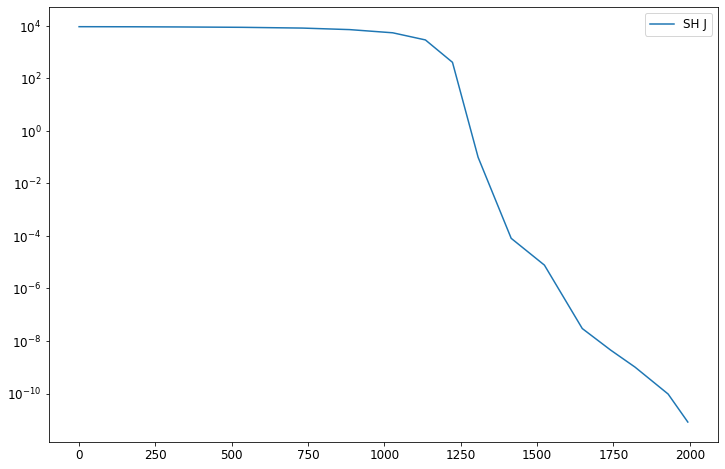

In [16]:
if 'SH' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,J_error_SH, label='SH J')
    plt.legend()

In [17]:
# compute the error in the target
from pymor.discretizers.builtin.cg import (L2ProductP1, L2ProductQ1, InterpolationOperator)
from pymor.discretizers.builtin.grids.referenceelements import square
from pymor.discretizers.builtin.grids.boundaryinfos import EmptyBoundaryInfo
if data['grid'].reference_element is square:
    L2_OP = L2ProductQ1
else:
    L2_OP = L2ProductP1
if mu_d is None:
    if 'SH' in optimization_methods or 'All' in optimization_methods:
        empty_bi = EmptyBoundaryInfo(data['grid'])
        u_d = InterpolationOperator(data['grid'], ConstantFunction(u_d,2)).as_vector()
        diff= u.to_numpy()-u_d.to_numpy()
        diff_= opt_fom.solution_space.from_numpy(diff)
        Restricted_L2_OP = L2_OP(data['grid'], empty_bi, dirichlet_clear_rows=False, coefficient_function=domain_of_interest)
        print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]))
        print("{}".format(Restricted_L2_OP.apply2(diff_,diff_)[0][0]/Restricted_L2_OP.apply2(u_d,u_d)))

# TR-RB approaches

In [18]:
import time
from pdeopt.model import build_initial_basis
from pdeopt.reductor import QuadraticPdeoptStationaryCoerciveReductor
from pdeopt.TR import TR_algorithm, TR_algorithm_with_optional_enrichment

from pymor.parameters.functionals import MinThetaParameterFunctional
ce = MinThetaParameterFunctional(opt_fom.primal_model.operator.coefficients, mu_bar)

set_defaults({'pymor.operators.constructions.induced_norm.raise_negative': False})
set_defaults({'pymor.operators.constructions.induced_norm.tol': 1e-20})

## Newton Method

### NCD-corrected

#### Lagrange Basis (Method 4)

In [19]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_4' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'NewtonMethod',  'iterative_solver': iterative_solver,
                 'JFE_start': J_start} # This is not cheating because the quantity to compute this are accessible when preparing pdeopt_reductor
                                       # so the computational time to compute this is already

    extension_params = {'Enlarge_radius': True, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_4, times_4, Js_4, FOC_4, data_4 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space,
                                                TR_parameters, extension_params)
    
    times_full_4_actual, J_error_4_actual, mu_error_4_actual, FOC_4_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_4, Js_4, times_4, tictoc, FOC_4)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.09703268551123091, 0.059250902425815016, 0.0975415923968396, 0.07433343943069282, 0.07279559421375438, 0.029448054602233875, 0.09786470092986177, 0.010560722968413087], heaters: [25.298236238344394, 43.47915324044458, 77.93829217937525, 19.768507460025308, 86.29932355992223, 98.34006771753127, 16.384224140469872, 59.73339439328592, 0.8986097667554982, 38.65712826436294, 4.4160057931499574, 95.66529677142358], walls: [0.045024298070780275, 0.09502528741120238, 0.07916483362866845, 0.08696320661171561, 0.019383628595854945, 0.009807487233777935, 0.06107241533433251, 0.018877287912544373]}
Starting value of the cost: 9247.91203621758
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
Using CG for the linear system
Using CG for the linear

Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Subproblem converged: mu_diff = 1.8162193432456207e-09, J_diff = 5.194739081028488e-13, FOC = 1.951323832333288e-10
relative differences mu 1.8162193432456207e-09 and J 5.194739081028488e-13
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Enrichment completed... length of Bases are 8 and 8
k: 6 - j 7 - Cost Functional: 1.0000001411928523 - mu: {doors: [0.01, 0.09999825512162037, 0.09999390892794632, 0.1, 0.01024470191872932, 0.01, 0.01, 0.01], heaters: [24.482467013786316, 25.50653753779165, 28.498695880784773, 29.259323926907978, 29.200592251380733, 27.446250379256448, 35.67670075717403, 50.517540417223465, 37.24461616591882, 31.711877253567536, 28.19850962824742, 25.83541061600302], walls: [0.0025495581177103063, 0.09997936420737784, 0.0025, 0.0025, 0.1, 

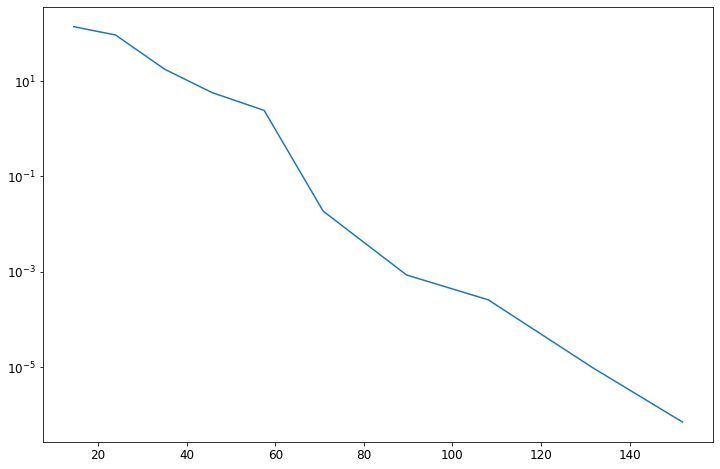

In [20]:
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,mu_error_4_actual)

#### Lagrange Basis with optional enrichment (Method 4.a)

In [21]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'NewtonMethod',  'iterative_solver': iterative_solver,
                 'tau_g': tau_g, 'tau_grad': tau_grad, 'beta_3': beta_3,
                 'minimum_radius': minimum_radius, 'maximum_radius': maximum_radius, 
                 'JFE_start': J_start}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_4bis, times_4bis, Js_4bis, FOC_4bis, data_4bis = TR_algorithm_with_optional_enrichment(opt_rom, pdeopt_reductor, parameter_space,
                                                TR_parameters, extension_params)
    
    times_full_4bis_actual, J_error_4bis_actual, mu_error_4bis_actual, FOC_4bis_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_4bis, Js_4bis, times_4bis, tictoc, FOC_4bis)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.09703268551123091, 0.059250902425815016, 0.0975415923968396, 0.07433343943069282, 0.07279559421375438, 0.029448054602233875, 0.09786470092986177, 0.010560722968413087], heaters: [25.298236238344394, 43.47915324044458, 77.93829217937525, 19.768507460025308, 86.29932355992223, 98.34006771753127, 16.384224140469872, 59.73339439328592, 0.8986097667554982, 38.65712826436294, 4.4160057931499574, 95.66529677142358], walls: [0.045024298070780275, 0.09502528741120238, 0.07916483362866845, 0.08696320661171561, 0.019383628595854945, 0.009807487233777935, 0.06107241533433251, 0.018877287912544373]}
Starting value of the cost: 9247.91203621758
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
Using CG for the linear system
Using CG for the linear

Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Subproblem converged: mu_diff = 2.049632375138818e-17, J_diff = 5.68476158098672e-14, FOC = 2.5491186667666825e-07
relative differences mu 2.049632375138818e-17 and J 5.68476158098672e-14
Sufficient decrease condition fulfilled
Enriching the RB model
building simple coercive dual reductor...
Enrichment completed... length of Bases are 6 and 6
enlarging the TR radius to 6.4
k: 6 - j 12 - Cost Functional: 1.000023304355068 - mu: {doors: [0.010725957321578106, 0.099963666137903, 0.09989714377715478, 0.1, 0.01, 0.01, 0.011965776388204981, 0.01], heaters: [24.482476746945974, 25.506563016331143, 28.498770769069765, 29.25941575660988, 29.200695115324084, 27.446354275592668, 35.67680858464929, 50.51763426901917, 37.244677087605986, 31.71190829827855, 28.19851969986258, 25.8354090

Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Subproblem converged: mu_diff = 2.0980406205681896e-15, J_diff = 0.0, FOC = 2.9854647874402456e-08
relative differences mu 2.0980406205681896e-15 and J 0.0

Stopping criteria fulfilled: FOC condition: 3.940789629019464e-06
k: 10 - j 7 - Cost Functional: 0.9999999998587331 - mu: {doors: [0.010002214774937587, 0.09999993421836546, 0.09999983373157369, 0.1, 0.010001958406039015, 0.01, 0.01000131634210528, 0.01], heaters: [24.482459911320472, 25.50653089425238, 28.498690524167912, 29.25932054893182, 29.20058991072556, 27.446249393098643, 35.676701549757446, 50.51753858505051, 37.2446119654135, 31.71187121914401, 28.198502571884685, 25.835402090079334], walls: [0.0025007247367578767, 0.09999982735706588, 0.0025, 0.0025, 0.1, 0.002500119941221383, 0.0057302082138410895, 0.002500158181123174]}
Computing only t

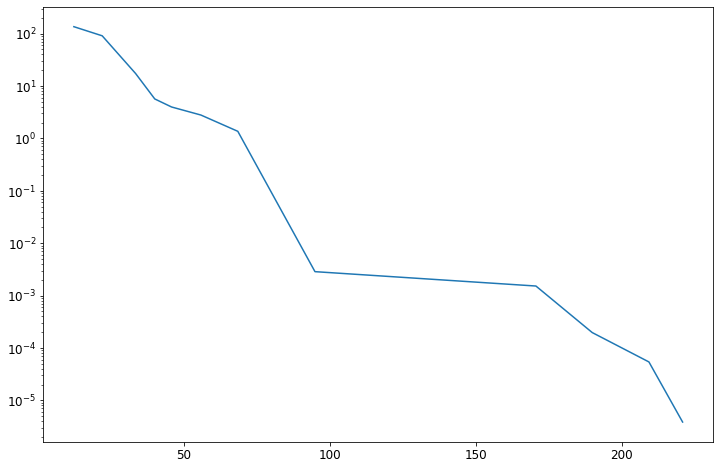

In [22]:
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,mu_error_4bis_actual)

#### Directional Taylor Basis (Method 5)

In [23]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_5' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'AdaptiveTaylor_Newton',  'iterative_solver': iterative_solver,
                 'JFE_start': J_start}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_5, times_5, Js_5, FOC_5, data_5 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_5_actual, J_error_5_actual, mu_error_5_actual, FOC_5_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_5, Js_5, times_5, tictoc, FOC_5)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.09703268551123091, 0.059250902425815016, 0.0975415923968396, 0.07433343943069282, 0.07279559421375438, 0.029448054602233875, 0.09786470092986177, 0.010560722968413087], heaters: [25.298236238344394, 43.47915324044458, 77.93829217937525, 19.768507460025308, 86.29932355992223, 98.34006771753127, 16.384224140469872, 59.73339439328592, 0.8986097667554982, 38.65712826436294, 4.4160057931499574, 95.66529677142358], walls: [0.045024298070780275, 0.09502528741120238, 0.07916483362866845, 0.08696320661171561, 0.019383628595854945, 0.009807487233777935, 0.06107241533433251, 0.018877287912544373]}
Starting value of the cost: 9247.91203621758
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
Using CG for the linear system
Using CG for the linear

Computing the approximate Cauchy point and then start the Newton method
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Subproblem converged: mu_diff = 3.74831005150968e-09, J_diff = 1.8840488500154989e-13, FOC = 3.192399920336551e-11
relative differences mu 3.74831005150968e-09 and J 1.8840488500154989e-13
enriching to check the sufficient decrease condition
building simple coercive dual reductor...
Length of Bases are 15 and 15
k: 6 - j 11 - Cost Functional: 1.000000024494569 - mu: {doors: [0.01, 0.1, 0.09999865621453835, 0.1, 0.010040642116602706, 0.010065290913035525, 0.01, 0.010007418942736964], heaters: [24.482458622028116, 25.506530089185034, 28.49869060773204, 29.25932129233661, 29.200591148511457, 27.44625084416055, 35.

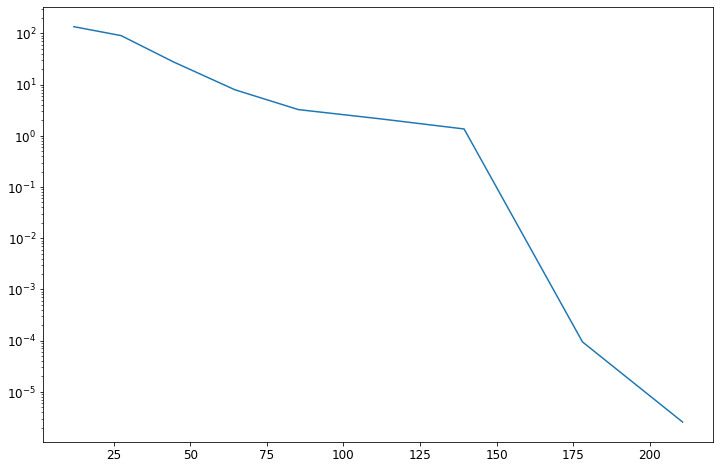

In [24]:
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,mu_error_5_actual)

#### Directional Taylor Basis with optional enrichment (Method 5.a)

In [25]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu,  'iterative_solver': iterative_solver,
                 'tau_g': tau_g, 'tau_grad': tau_grad, 'beta_3': beta_3,
                 'minimum_radius': minimum_radius, 'maximum_radius': maximum_radius, 
                 'opt_method': 'AdaptiveTaylor_Newton',  
                 'JFE_start': J_start} 

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_5bis, times_5bis, Js_5bis, FOC_5bis, data_5bis = TR_algorithm_with_optional_enrichment(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_5bis_actual, J_error_5bis_actual, mu_error_5bis_actual, FOC_5bis_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_5bis, Js_5bis, times_5bis, tictoc, FOC_5bis)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.09703268551123091, 0.059250902425815016, 0.0975415923968396, 0.07433343943069282, 0.07279559421375438, 0.029448054602233875, 0.09786470092986177, 0.010560722968413087], heaters: [25.298236238344394, 43.47915324044458, 77.93829217937525, 19.768507460025308, 86.29932355992223, 98.34006771753127, 16.384224140469872, 59.73339439328592, 0.8986097667554982, 38.65712826436294, 4.4160057931499574, 95.66529677142358], walls: [0.045024298070780275, 0.09502528741120238, 0.07916483362866845, 0.08696320661171561, 0.019383628595854945, 0.009807487233777935, 0.06107241533433251, 0.018877287912544373]}
Starting value of the cost: 9247.91203621758
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the Newton method
Using CG for the linear system
Using CG for the linear

Using CG for the linear system
Using CG for the linear system
CG truncated at iteration: 4 with residual: 0.02865, because p_k is not a descent direction
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Using CG for the linear system
Subproblem converged: mu_diff = 8.726003241933131e-16, J_diff = 0.0, FOC = 7.322147383686798e-08
relative differences mu 8.726003241933131e-16 and J 0.0
Sufficient decrease condition fulfilled
Enriching the RB model
building simple coercive dual reductor...
Length of Bases are 13 and 13
enlarging the TR radius to 12.8
k: 6 - j 11 - Cost Functional: 1.0000013633693925 - mu: {doors: [0.010343737730368043, 0.09999220207906402, 0.0999987563638459, 0.09999869658929225, 0.010784648687228497, 0.01, 0.01, 0.01], heaters: [24.48248723666176, 25.50655766456855, 28.498716803974606, 29.259345963274974, 

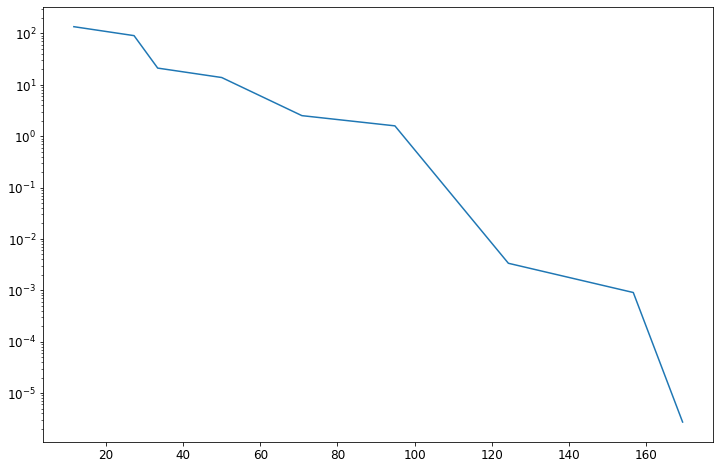

In [26]:
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,mu_error_5bis_actual)

### Aggregated

#### excluding directional sensitivities (Method 6) -- (b)

In [27]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)

if 'Method_6' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                unique_basis=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'NewtonMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_6, times_6, Js_6, FOC_6, data_6 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_6_actual, J_error_6_actual, mu_error_6_actual, FOC_6_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_6, Js_6, times_6, tictoc, FOC_6)

In [28]:
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual, mu_error_6_actual)

#### including directional sensitivities (Method 7) -- (d)

In [29]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)

if 'Method_7' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                prepare_for_hessian=True,
                                                unique_basis=True,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'estimate_tolerance': estimate_tolerance, 
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'AdaptiveTaylor_Newton',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}
    
    mus_7, times_7, Js_7, FOC_7, data_7 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_7_actual, J_error_7_actual, mu_error_7_actual, FOC_7_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_7, Js_7, times_7, tictoc, FOC_7)

In [30]:
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,mu_error_7_actual)

## NCD corrected BFGS Method (KMSOV'20)

In [31]:
tic = time.time()
params = [mu]

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=True)
opt_fom = opt_fom.with_(adjoint_approach=True)

if 'Method_8' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(
        opt_fom, params, build_sensitivities=False)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                RBbasis, dual_RBbasis, 
                                                opt_product=opt_fom.opt_product,
                                                coercivity_estimator=ce,
                                                reductor_type=reductor_type, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()

    tictoc = time.time() - tic

    TR_parameters = {'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_8, times_8, Js_8, FOC_8, data_8 = TR_algorithm(opt_rom, pdeopt_reductor, parameter_space, 
                                                TR_parameters, extension_params)
    
    times_full_8_actual, J_error_8_actual, mu_error_8_actual, FOC_8_actual = compute_errors(
        opt_fom, parameter_space, J_start, J_opt, mu, mu_opt_as_array, mus_8, Js_8, times_8, tictoc, FOC_8)

Starting with two bases. Primal and dual have length 1 and 1
building simple coercive primal reductor...
building simple coercive dual reductor...
starting parameter {doors: [0.09703268551123091, 0.059250902425815016, 0.0975415923968396, 0.07433343943069282, 0.07279559421375438, 0.029448054602233875, 0.09786470092986177, 0.010560722968413087], heaters: [25.298236238344394, 43.47915324044458, 77.93829217937525, 19.768507460025308, 86.29932355992223, 98.34006771753127, 16.384224140469872, 59.73339439328592, 0.8986097667554982, 38.65712826436294, 4.4160057931499574, 95.66529677142358], walls: [0.045024298070780275, 0.09502528741120238, 0.07916483362866845, 0.08696320661171561, 0.019383628595854945, 0.009807487233777935, 0.06107241533433251, 0.018877287912544373]}
Starting value of the cost: 9247.91203621758
******************************* 

___ starting subproblem
Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the 

Computing the approximate Cauchy point and then start the BFGS method
boundary criterium of the TR satisfied, so stopping the sub-problem solver
checked sufficient condition, starting enrichment
building simple coercive dual reductor...
Enrichment completed... length of Bases are 9 and 9
k: 7 - j 6 - Cost Functional: 1.2039301966773985 - mu: {doors: [0.013566773567290746, 0.0996587646536695, 0.09999841157515142, 0.09998996485619033, 0.010196579042398684, 0.010097194235286907, 0.02674885970291755, 0.01038818112601565], heaters: [24.477908824905544, 25.582032662505224, 28.721093285113234, 29.206370292114546, 29.45878624888827, 27.76901892538658, 35.578182692033465, 50.55210410078967, 37.06625542980891, 31.735782887626446, 28.078903448193152, 26.15327428244689], walls: [0.09328004210158157, 0.09990364512910263, 0.021663181393342775, 0.04990859286291493, 0.09865563431131902, 0.0029601184257542854, 0.008831317613671235, 0.0025600854646307784]}
computing the fom gradient since the model was 

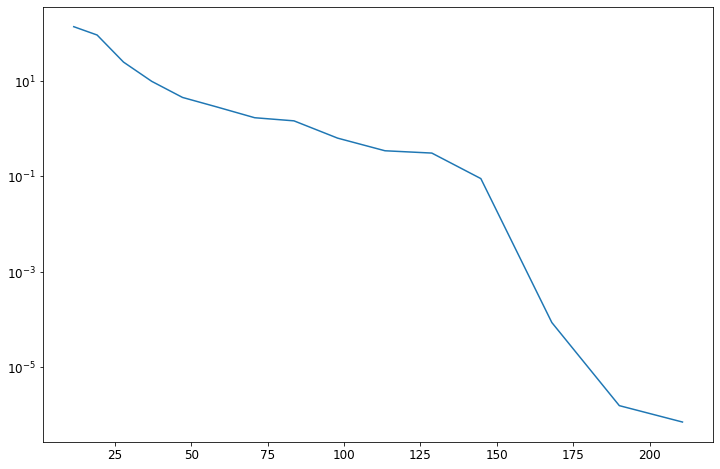

In [32]:
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual)

## Qian-Grepl-Method

In [33]:
#Qian-Grepl

# make sure to use the correct config
opt_fom = opt_fom.with_(use_corrected_functional=False)
opt_fom = opt_fom.with_(adjoint_approach=False)
tic = time.time()
params = [mu]

if 'Method_9' in optimization_methods or 'All' in optimization_methods:

    RBbasis, dual_RBbasis = build_initial_basis(opt_fom, params)

    pdeopt_reductor = QuadraticPdeoptStationaryCoerciveReductor(opt_fom, 
                                                                RBbasis, dual_RBbasis, 
                                                                opt_product=opt_fom.opt_product, 
                                                                prepare_for_hessian=False,
                                                                prepare_for_gradient_estimate=True,
                                                                coercivity_estimator=ce, mu_bar=mu_bar)

    opt_rom = pdeopt_reductor.reduce()
    tictoc = time.time() - tic
    
    TR_parameters = {'Qian-Grepl': True,
                 'Qian-Grepl_subproblem': Qian_Grepl_subproblem, 'beta': beta,
                 'safety_tolerance': safety_tol,
                 'radius': radius, 'FOC_tolerance': FOC_tolerance, 
                 'sub_tolerance': sub_tolerance,
                 'max_iterations': max_it, 'max_iterations_subproblem': max_it_sub, 
                 'max_iterations_armijo': max_it_arm,
                 'initial_step_armijo': init_step_armijo, 
                 'armijo_alpha': armijo_alpha, 
                 'epsilon_i': epsilon_i, 
                 'control_mu': control_mu,
                 'starting_parameter': mu, 
                 'opt_method': 'BFGSMethod',  'iterative_solver': iterative_solver}

    extension_params = {'Enlarge_radius': False, 'timings': True, 
                        'opt_fom': opt_fom, 'return_data_dict': True}

    mus_9, times_9, Js_9, FOC_9, data_9 = TR_algorithm(
        opt_rom, pdeopt_reductor, parameter_space, TR_parameters, extension_params)

    times_full_9_actual, J_error_9_actual, FOC_9_actual, mu_error_9_actual = compute_actual_errors(
        opt_fom, parameter_space, J_start, J_opt, mus_9, times_9, tictoc, mu, mu_opt_as_array)
    

In [34]:
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,J_error_9_actual)

# Results

In [35]:
print(mu_opt)
u = opt_fom.solve(mu_opt)
opt_fom.visualize(u)

{doors: [0.01, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01], heaters: [24.482459844744305, 25.50653083120525, 28.498690473458193, 29.259320514801086, 29.200589887342804, 27.446249378647696, 35.67670157200817, 50.517538581782496, 37.24461195443051, 31.711871202474516, 28.19850255174135, 25.835402061993246], walls: [0.0025, 0.1, 0.0025, 0.0025, 0.1, 0.0025, 0.00573211642415904, 0.0025]}


Output()

## Plot results

### J error

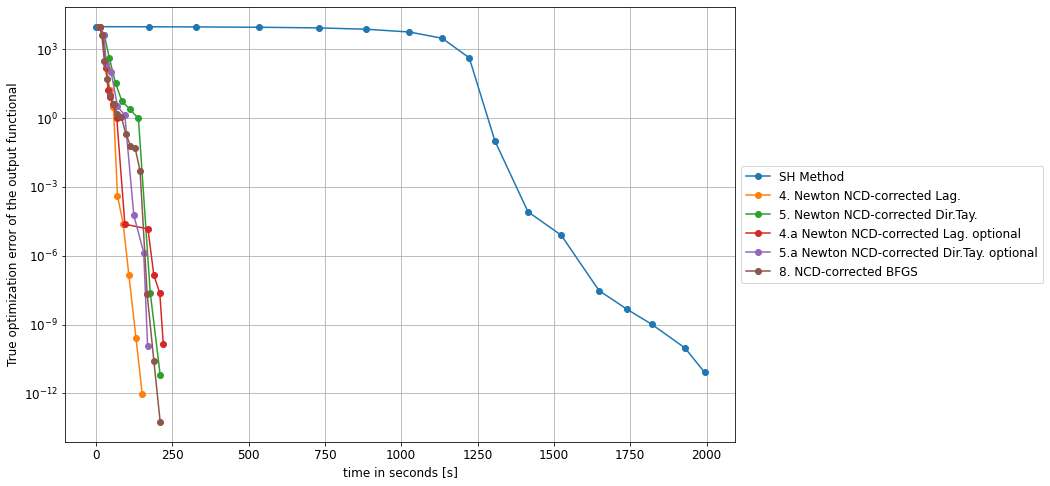

In [36]:
timings_figure = plt.figure()
if 'SH' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,J_error_SH,'o-', label='SH Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,J_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,J_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,J_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag. optional')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,J_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay. optional')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,J_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,J_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,J_error_8_actual,'o-', label='8. NCD-corrected BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,J_error_9_actual,'o-', label='9. Qian-Grepl')

plt.xlabel('time in seconds [s]')
plt.ylabel('True optimization error of the output functional')
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot FOC

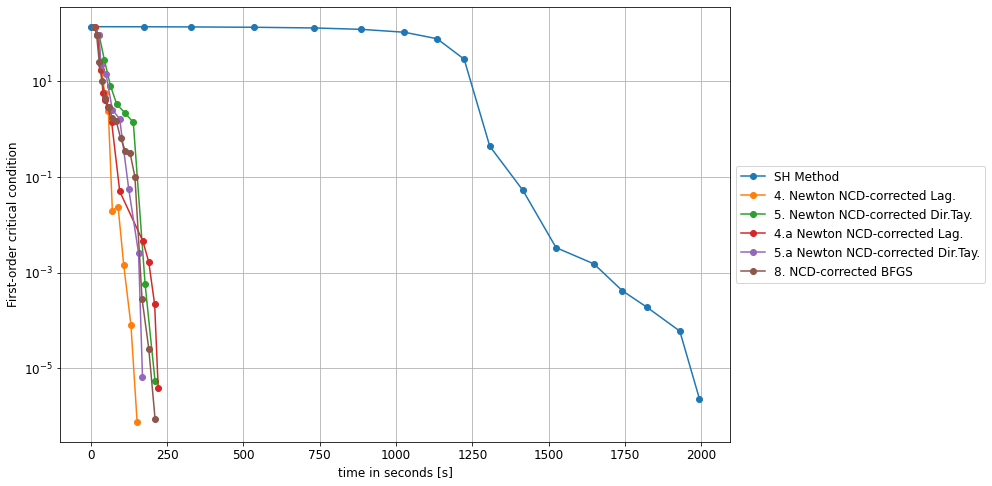

In [37]:
timings_figure = plt.figure()

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH, FOC_SH,'o-', label='SH Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual, FOC_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual, FOC_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual, FOC_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual, FOC_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual, FOC_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual, FOC_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual, FOC_8_actual,'o-', label='8. NCD-corrected BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual, FOC_9_actual,'o-', label='9. Qian-Grepl')

plt.xlabel('time in seconds [s]')
plt.ylabel('First-order critical condition')
# plt.xlim([-1,30])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Plot Mu error

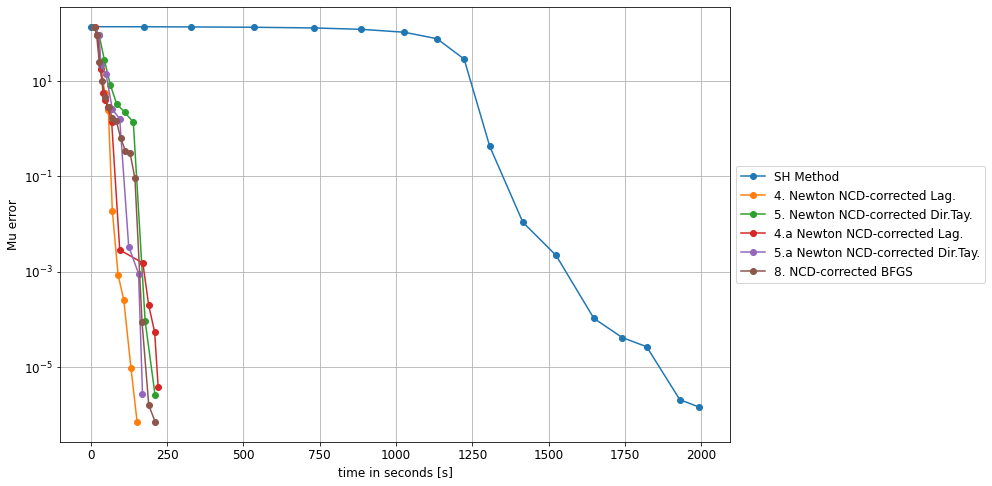

In [38]:
if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_SH,mu_error_SH,'o-', label='SH Method')
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4_actual,mu_error_4_actual,'o-', label='4. Newton NCD-corrected Lag.')
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5_actual,mu_error_5_actual,'o-', label='5. Newton NCD-corrected Dir.Tay.')
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_4bis_actual,mu_error_4bis_actual,'o-', label='4.a Newton NCD-corrected Lag.')
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_5bis_actual,mu_error_5bis_actual,'o-', label='5.a Newton NCD-corrected Dir.Tay.')
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_6_actual,mu_error_6_actual,'o-', label='6. Newton Aggr.')
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_7_actual,mu_error_7_actual,'o-', label='7. Newton Aggr. Dir.Tay')
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_8_actual,mu_error_8_actual,'o-', label='8. NCD-corrected BFGS')
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    plt.semilogy(times_full_9_actual,mu_error_9_actual,'o-', label='9. Qian-Grepl')

plt.xlabel('time in seconds [s]')
plt.ylabel('Mu error')
#plt.xlim([-1,100])
plt.grid()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#timings_figure.savefig('compare_FEM_TR', format='pdf', bbox_inches="tight")

### Save the data

In [39]:
#save data
from pdeopt.tools import save_data

directory = f'results/Starter{seed}'

if 'SH' in optimization_methods or 'FOM' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_SH, J_error_SH, 1, mu_error=mu_error_SH, FOC=FOC_SH)
if 'Method_4' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4_actual, J_error_4_actual, 4, mu_error=mu_error_4_actual, FOC=FOC_4_actual, additional_data=data_4)
if 'Method_5' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5_actual, J_error_5_actual, 5, mu_error=mu_error_5_actual, FOC=FOC_5_actual, additional_data=data_5)
if 'Method_4_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_4bis_actual, J_error_4bis_actual, 2, mu_error=mu_error_4bis_actual, FOC=FOC_4bis_actual, additional_data=data_4bis)
if 'Method_5_optional' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_5bis_actual, J_error_5bis_actual, 3, mu_error=mu_error_5bis_actual, FOC=FOC_5bis_actual, additional_data=data_5bis)
if 'Method_6' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_6_actual, J_error_6_actual, 6, mu_error=mu_error_6_actual, FOC=FOC_6_actual, additional_data=data_6)
if 'Method_7' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_7_actual, J_error_7_actual, 7, mu_error=mu_error_7_actual, FOC=FOC_7_actual, additional_data=data_7)
if 'Method_8' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_8_actual, J_error_8_actual, 8, mu_error=mu_error_8_actual, FOC=FOC_8_actual, additional_data=data_8)
if 'Method_9' in optimization_methods or 'All' in optimization_methods:
    save_data(directory, times_full_9_actual, J_error_9_actual, 9, mu_error=mu_error_9_actual, FOC=FOC_9_actual, additional_data=data_9)    